# TM10007 Assignment Machine Learning

Fleur van den Bogaert (4555880), Tamir Themans (4471687), Nadine de Jong (4542045), Marjolein Muller (4649095)


## Data loading and importing python packages

In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [ ]:
# Import packages

# General
from adni.load_data import load_data
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from collections import Counter

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [ ]:
# Importing data
data = load_data()
data = data.replace(['AD', 'CN'], [1, 0])
label = data.pop('label')

print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)}')

The number of samples: 855
The number of features: 267


In [ ]:
# Drop all features with only zeros
zero_columns = data.columns[(data == 0).all()]

for i, column in enumerate(zero_columns): 
    data.drop(column, inplace=True, axis=1)

print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)}')

The number of samples: 855
The number of features: 263


In [ ]:
# Calculating amount of samples wit Alzheimers Disease (AD)

AD_amount = sum(label)
print(f'Amount of samples with Alzheimers Disease (AD): {AD_amount}/{len(label)}')

Amount of samples with Alzheimers Disease (AD): 519/855


## Choosing Scaler and kernel for PCA

In [ ]:
# Function for different scaling and pca kernels

def pick_scale_pca(data, label, scaler_type, n_components):
  """
  arguments:
  data:             data (features)
  label:            labels (classes)
  scaler_type:      type of scaler (StandardScaler(), RobustScaler()) or None
  """
  # Scaler choice defined
  if scaler_type:
    data = scaler_type.fit_transform(data)

  # PCA plot using different kernels
  fig = plt.figure(figsize=(4*5,4))
  
  num = 0

  for kernel_type in ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']:
    pca = KernelPCA(n_components = n_components, kernel = kernel_type)

    data_pca = pca.fit_transform(data)

    num += 1
    sc = fig.add_subplot(1, 5, num)
    sc.scatter(data_pca[:, 0], data_pca[:, 1], marker='o',c=label, s=25, edgecolor='k', cmap=plt.cm.Paired)
    sc.set_title(kernel_type, loc='right')
    sc.set_xlabel('PCA1')
    sc.set_ylabel('PCA2')
  plt.tight_layout()

Order: No Scaler, StandardScaler, RobustScaler


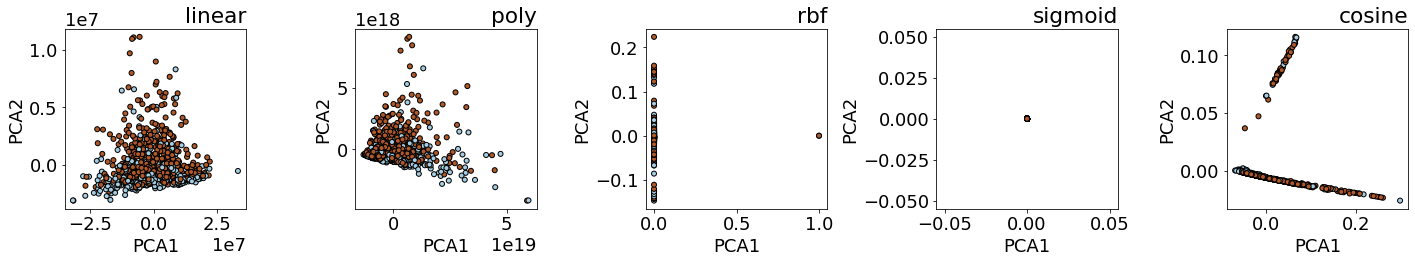

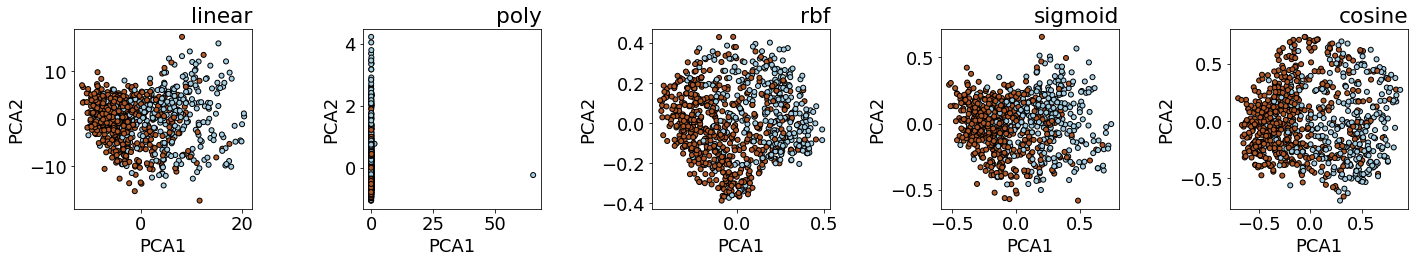

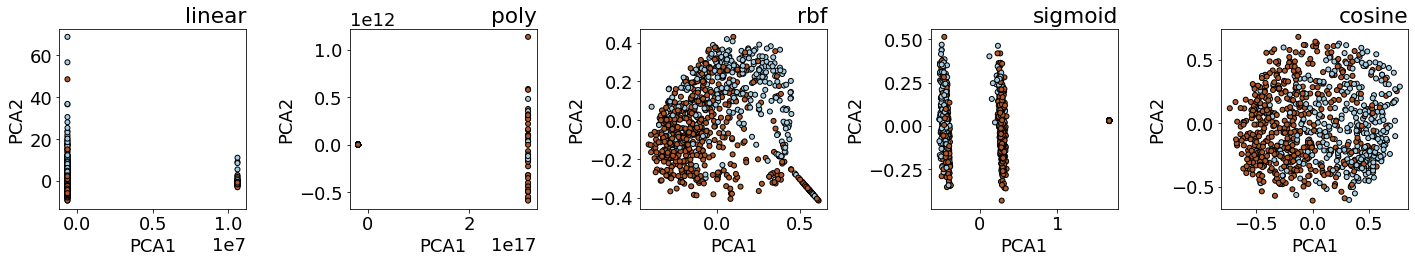

In [ ]:
# Comparing Scaler types and PCA kernels
print('Order: No Scaler, StandardScaler, RobustScaler')
pick_scale_pca(data, label, None, 2)
pick_scale_pca(data, label, StandardScaler(), 2)
pick_scale_pca(data, label, RobustScaler(), 2)

## Classifier

In [ ]:
def apply_classification(cl, parameters, data, label):
  # Predefining outer and innner cross-validations
  cv_10fold = model_selection.StratifiedKFold(n_splits=10, random_state = 1 , shuffle = True)
  cv_3fold = model_selection.StratifiedKFold(n_splits=3, random_state = 1, shuffle = True)
  
  # initializing 
  outer_results_auc = []
  outer_results_acc = []
  outer_results_prec = []
  outer_results_recl = []

  tprs = []
  mean_fpr = np.linspace(0, 1, 100)
  
  fig, ax = plt.subplots()
  f, axes = plt.subplots(1, 10, figsize=(30,4))

  num = 0

  classifier = cl()

  # Nested cross-valdation loop 
  for train_index, test_index in cv_10fold.split(data, label):
      # Split the data properly
      x_train = data.iloc[train_index]
      y_train = label[train_index]
      
      x_test = data.iloc[test_index]
      y_test = label[test_index]

      # Scale the train and test set
      scaler = StandardScaler()
      scaler.fit(x_train)
      x_train_scaled = scaler.transform(x_train)
      x_test_scaled = scaler.transform(x_test)

      # Apply PCA with n components include 80% of variance 
      pca = PCA(0.80)
      pca.fit(x_train_scaled)
      x_train_pca = pca.transform(x_train_scaled)
      x_test_pca = pca.transform(x_test_scaled)
      print(f"Number of PCA's needed to include 80% of variance: {x_train_pca.shape[1]}")
      
      results = pd.DataFrame()
      best_parameters = pd.DataFrame()
      
      # inner cross validation to perform hyperparameter optimalization
      for train_train_index, train_validation_index in cv_3fold.split(x_train_pca, y_train):
          x_train_train = x_train_pca[train_train_index]
          y_train_train = y_train[train_train_index]
      
          x_train_validation = x_train_pca[train_validation_index]
          y_train_validation = y_train[train_validation_index]

          # Create a grid search to find the optimal parameters using 3-fold cross validation
          grid_search = model_selection.GridSearchCV(classifier,param_grid=parameters, cv=cv_3fold, scoring='roc_auc')
          grid_search.fit(x_train_train, y_train_train)
      
          # Get resulting classifier
          clf = grid_search.best_params_
          clf2 = grid_search.best_estimator_
          
          best_parameters = best_parameters.append(clf, ignore_index=True)

          # Test the classifier on the training data
          probabilities = clf2.predict_proba(x_train_train)
          scores = probabilities[:, 1]
      
          # Get the auc of the test above
          auc = metrics.roc_auc_score(y_train_train, scores)
          results = results.append({**clf, **{'auc': auc, 'set': 'train'}}, ignore_index=True)

          # Test the classifier on the validation data
          probabilities_validation = clf2.predict_proba(x_train_validation)
          scores_validation = probabilities_validation[:, 1]
      
          # Get the auc of the test above
          auc_validation = metrics.roc_auc_score(y_train_validation, scores_validation)
          results = results.append({**clf, **{'auc': auc_validation, 'set': 'validation'}}, ignore_index=True)
          
      # Create results dataframe and plot it
      seaborn.boxplot(y='auc', x='set', data=results, ax=axes[num]).set_title(f'AUC train vs validation. \n Cv iteration {num+1}')
      num += 1

      # Several steps for calculating the median of the best parameters specifically per classifier to find the optimal parameters
      if cl == SVC:
        # For SVM the kernel should be chosen first
        count_kernel = dict(Counter(best_parameters['kernel']))
        mode = [k for k, v in count_kernel.items() if v == max(list(count_kernel.values()))]     
        optimal_kernel = mode[0]
        params_kernel = best_parameters[best_parameters['kernel'] == optimal_kernel]
        optimal_params = params_kernel.median(axis = 0)
        optimal_params = optimal_params.append(pd.Series({'kernel': optimal_kernel}))
      elif cl == MLPClassifier:
        # For Neural Network some parameters need to be integers and others should not
        best_hidden_layer_sizes = best_parameters.pop('hidden_layer_sizes')
        best_max_iter = best_parameters.pop('max_iter')
        best_alpha = best_parameters.pop('alpha')
        best_tol= best_parameters.pop('tol')
        best_solver = best_parameters.pop('solver')

        optimal_hidden_layer_sizes = int(np.median(best_hidden_layer_sizes))
        optimal_max_iter = int(np.median(best_max_iter))
        optimal_alpha = np.median(best_alpha)
        optimal_tol = np.median(best_tol)
        count_activation = dict(Counter(best_parameters['activation']))
        mode = [k for k, v in count_activation.items() if v == max(list(count_activation.values()))]  
        optimal_activation = mode[0]
        optimal_solver = best_solver.iloc[0]
        optimal_params = {'hidden_layer_sizes': optimal_hidden_layer_sizes, 'max_iter': optimal_max_iter, 'activation': optimal_activation, 'solver': optimal_solver, 'alpha': optimal_alpha, 'tol': optimal_tol}
      else:
        # In all other cases taking integer of median is okay
        optimal_params = best_parameters.median(axis = 0)
        optimal_params = optimal_params.astype(int)

      # Use the optimal parameters validate the optimal classifier
      clf3 = classifier.set_params(**optimal_params)

      # Fit classifier with optimal parameters on the entire dataset
      clf3.fit(x_train_pca, y_train)

      # Test the classifier with optimal parameters on the real test set
      probabilities = clf3.predict_proba(x_test_pca)
      scores = probabilities[:, 1]
      y_pred = np.around(scores)

      # Get statistics of performance of classifier with optimal parameters on real test set
      auc = metrics.roc_auc_score(y_test, scores)
      acc = metrics.accuracy_score(y_test, y_pred)
      prec = metrics.precision_score(y_test, y_pred)
      recl = metrics.recall_score(y_test, y_pred)

      outer_results_auc.append(auc)
      outer_results_acc.append(acc)
      outer_results_prec.append(prec)
      outer_results_recl.append(recl)

      print(f'Cross validation iteration {num}/10: \n The AUC on the test set is {auc:.3f}, \n The accuracy on the test set is {acc:.3f}, \n The precision on the test set is {prec:.3f}, \n The recall on the test set is {recl:.3f}, \n Using parameter(s): \n{optimal_params} \n ')
      
      # Print ROC curves of these performances for all 10 outer folds in one figure 
      roc = metrics.plot_roc_curve(clf3, x_test_pca, y_test, name='ROC fold {}'.format(num), alpha=0.3, lw=1, ax=ax)
      interp_tpr = np.interp(mean_fpr, roc.fpr, roc.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)

  # Mean + standard deviation of optimal parameters of all 10 outer cross validation folds
  print('Mean statistics:')
  print(f'Mean area under the curve: {np.mean(outer_results_auc):.3f} \u00B1 {np.std(outer_results_auc):.3f}')
  print(f'Mean accuracy: {np.mean(outer_results_acc):.3f} \u00B1 {np.std(outer_results_acc):.3f}')
  print(f'Mean precision: {np.mean(outer_results_prec):.3f} \u00B1 {np.std(outer_results_prec):.3f}')
  print(f'Mean recall: {np.mean(outer_results_recl):.3f} \u00B1 {np.std(outer_results_recl):.3f}')

  # Add the mean ROC over all 10 outer cross validation folds to the ROC plot
  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
  ax.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (np.mean(outer_results_auc), np.std(outer_results_auc)),lw=2, alpha=.8)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC curve")
  ax.legend(loc='best', fontsize='x-small')
  ax.get_figure()
  plt.tight_layout()

## Apply Classifiers

 Number of PCA's needed to include 80% of variance: 28
Cross validation iteration 1/10: 
 The AUC on the test set is 0.898, 
 The accuracy on the test set is 0.733, 
 The precision on the test set is 0.738, 
 The recall on the test set is 0.865, 
 Using parameter(s): 
n_neighbors    60
dtype: int64 
 
 Number of PCA's needed to include 80% of variance: 29
Cross validation iteration 2/10: 
 The AUC on the test set is 0.877, 
 The accuracy on the test set is 0.802, 
 The precision on the test set is 0.797, 
 The recall on the test set is 0.904, 
 Using parameter(s): 
n_neighbors    50
dtype: int64 
 
 Number of PCA's needed to include 80% of variance: 28
Cross validation iteration 3/10: 
 The AUC on the test set is 0.822, 
 The accuracy on the test set is 0.721, 
 The precision on the test set is 0.726, 
 The recall on the test set is 0.865, 
 Using parameter(s): 
n_neighbors    80
dtype: int64 
 
 Number of PCA's needed to include 80% of variance: 29
Cross validation iteration 4/10: 
 T

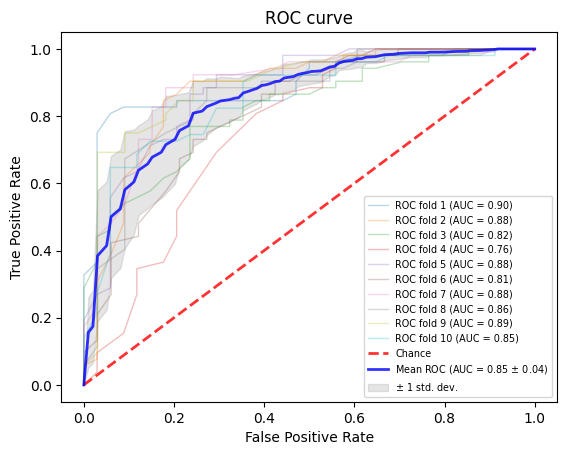

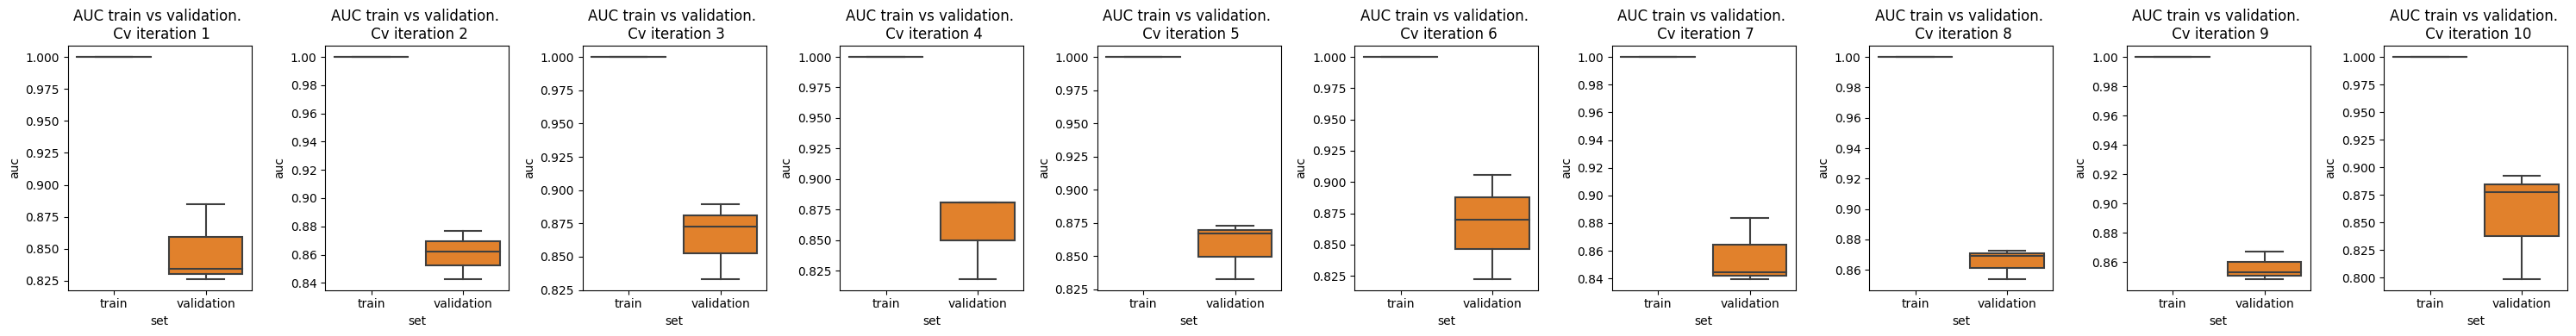

In [ ]:
# KNN
parameters_knn = {'n_neighbors': [1,2,3,4,5,7,9,11,13,15,20,25,30,35,40,45,50,60,70,80,90,100], 'weights': ['distance']}
knn = KNeighborsClassifier

apply_classification(knn, parameters_knn, data, label)

 Number of PCA's needed to include 80% of variance: 28
Cross validation iteration 1/10: 
 The AUC on the test set is 0.938, 
 The accuracy on the test set is 0.872, 
 The precision on the test set is 0.887, 
 The recall on the test set is 0.904, 
 Using parameter(s): 
C                  1
coef0              1
degree             3
gamma          0.001
probability        1
kernel          poly
dtype: object 
 
 Number of PCA's needed to include 80% of variance: 29
Cross validation iteration 2/10: 
 The AUC on the test set is 0.913, 
 The accuracy on the test set is 0.779, 
 The precision on the test set is 0.762, 
 The recall on the test set is 0.923, 
 Using parameter(s): 
C                0.55
coef0           0.505
degree              2
gamma          0.0055
probability         1
kernel           poly
dtype: object 
 
 Number of PCA's needed to include 80% of variance: 28
Cross validation iteration 3/10: 
 The AUC on the test set is 0.855, 
 The accuracy on the test set is 0.767, 
 The

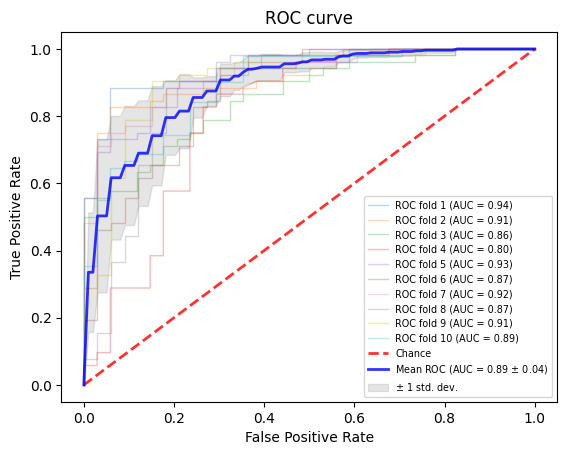

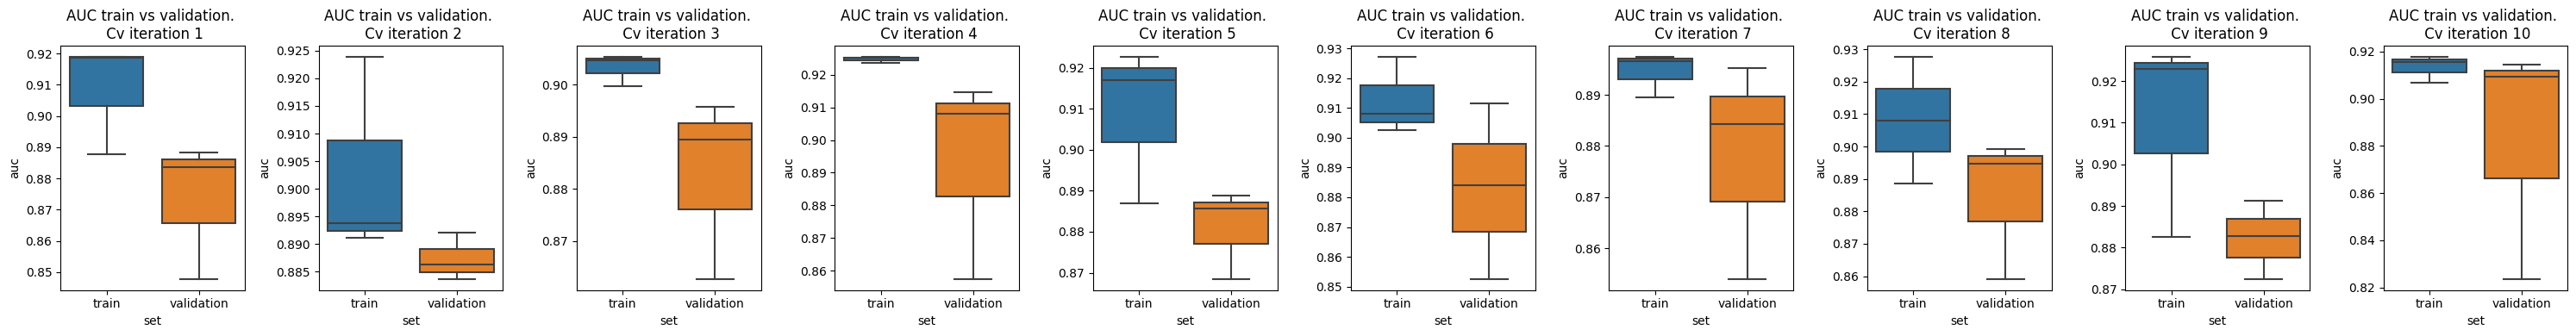

In [ ]:
# SVC
parameters_svc = {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01],'kernel': ['rbf', 'poly', 'sigmoid'], 'degree': [1, 3], 'coef0': [0.01, 0.1, 1], 'probability': [True]}
svc = SVC

apply_classification(svc, parameters_svc, data, label)

 Number of PCA's needed to include 80% of variance: 28
Cross validation iteration 1/10: 
 The AUC on the test set is 0.920, 
 The accuracy on the test set is 0.849, 
 The precision on the test set is 0.868, 
 The recall on the test set is 0.885, 
 Using parameter(s): 
bootstrap        1
n_estimators    80
dtype: int64 
 
 Number of PCA's needed to include 80% of variance: 29
Cross validation iteration 2/10: 
 The AUC on the test set is 0.854, 
 The accuracy on the test set is 0.779, 
 The precision on the test set is 0.762, 
 The recall on the test set is 0.923, 
 Using parameter(s): 
bootstrap        1
n_estimators    90
dtype: int64 
 
 Number of PCA's needed to include 80% of variance: 28
Cross validation iteration 3/10: 
 The AUC on the test set is 0.790, 
 The accuracy on the test set is 0.744, 
 The precision on the test set is 0.750, 
 The recall on the test set is 0.865, 
 Using parameter(s): 
bootstrap        1
n_estimators    80
dtype: int64 
 
 Number of PCA's needed to incl

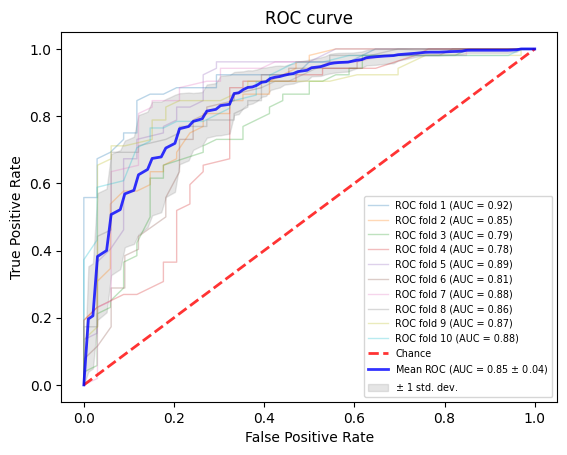

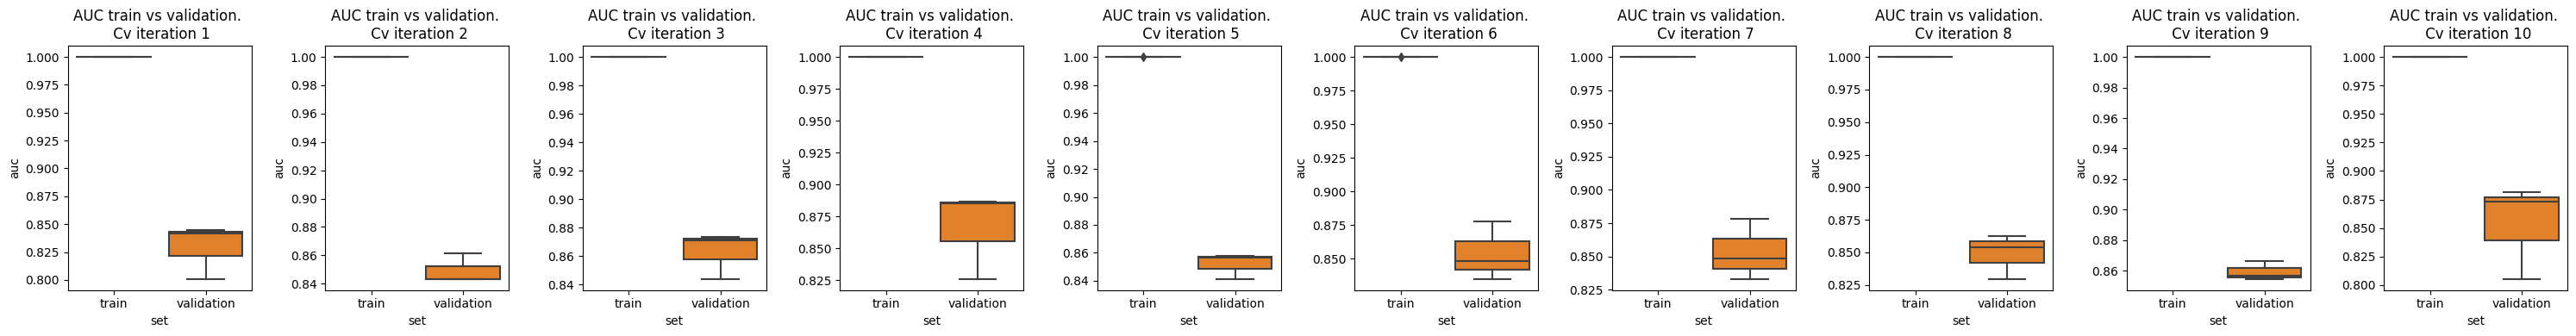

In [ ]:
# RandomForest
parameters_rf = {'n_estimators': list(range(50, 100, 5)), 'bootstrap': [True]}
rf = RandomForestClassifier

apply_classification(rf, parameters_rf, data, label)

 Number of PCA's needed to include 80% of variance: 28
Cross validation iteration 1/10: 
 The AUC on the test set is 0.924, 
 The accuracy on the test set is 0.872, 
 The precision on the test set is 0.902, 
 The recall on the test set is 0.885, 
 Using parameter(s): 
{'hidden_layer_sizes': 60, 'max_iter': 10000, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.1, 'tol': 0.0002} 
 
 Number of PCA's needed to include 80% of variance: 29
Cross validation iteration 2/10: 
 The AUC on the test set is 0.846, 
 The accuracy on the test set is 0.767, 
 The precision on the test set is 0.767, 
 The recall on the test set is 0.885, 
 Using parameter(s): 
{'hidden_layer_sizes': 60, 'max_iter': 10000, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.1, 'tol': 0.0002} 
 
 Number of PCA's needed to include 80% of variance: 28
Cross validation iteration 3/10: 
 The AUC on the test set is 0.827, 
 The accuracy on the test set is 0.744, 
 The precision on the test set is 0.768, 
 The recall on t

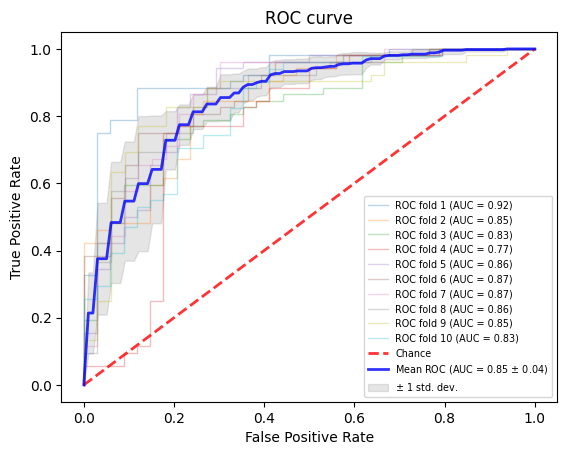

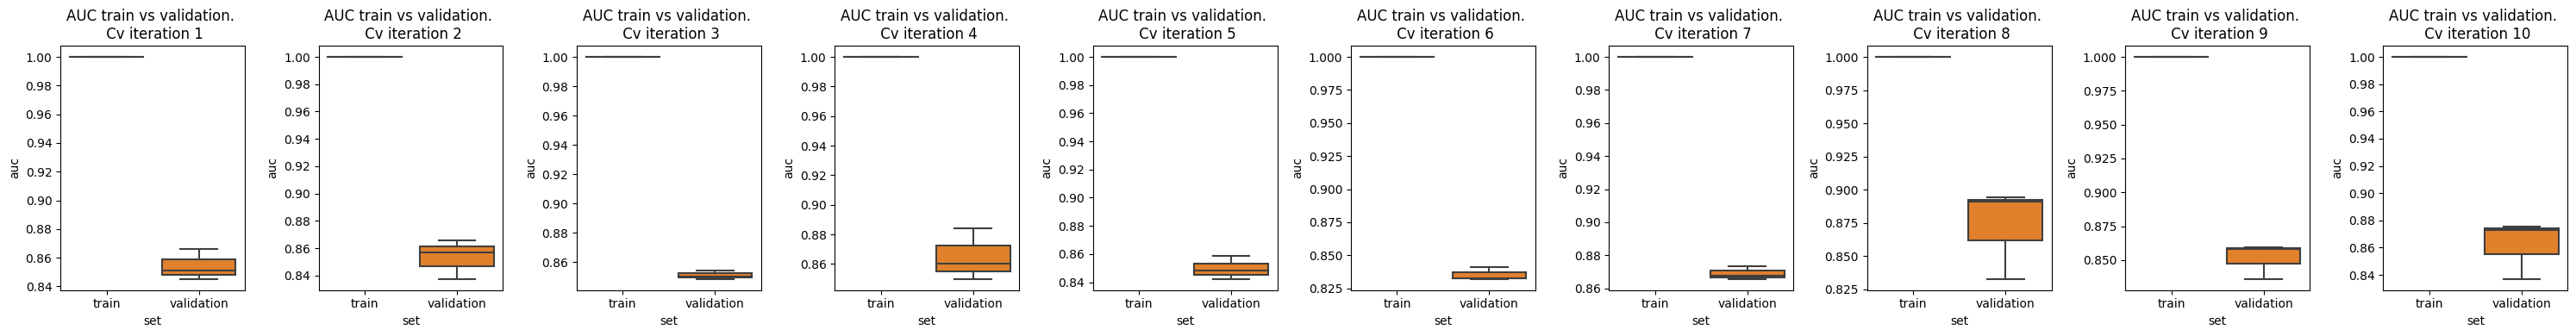

In [ ]:
# NeuralNetwork
parameters_nn = {'hidden_layer_sizes': [15, 30, 45, 60, 75], 'activation': ['relu', 'tanh'], 'solver': ['lbfgs'], 'alpha': list(10.0 ** -np.arange(1,7)), 'tol': [0.0002], 'max_iter': [10000]}
nn = MLPClassifier

apply_classification(nn, parameters_nn, data, label)